# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
from getRefXSecs import getXSecFor
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
import pyslha


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


def add_colorbar(mappable,label=""):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar

#### Create txname/process translator

In [2]:
processDict = {'TChiWZ' : r'$\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$',
              'TChiWH' : r'$\chi_1^\pm \, \chi_2^0 \to W \chi_1^0 \, h \chi_1^0$',
              'TChiWW' : r'$\chi_1^\pm \, \chi_1^\mp \to W \chi_1^0 \, W \chi_1^0$',
              'TDTM1F,TDTM2F' : r'$\chi_1^\pm \to \pi^\pm \chi_1^0$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0
dataDF['excludedRelic'] = dataDF['Omega'] > 0.13
#Xenon 1T curve (from micromegas):
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]
xenonF = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
@np.vectorize
def xenonUL(mDM):
    return 1e-8*np.exp(xenonF(np.log(mDM))) #90% upper limit on sigmaNucleon (pb)

rDD = (dataDF['Omega']/0.12)*(dataDF['proton_SI']+dataDF['neutron_SI'])/2.0
rDD = rDD/xenonUL(dataDF['mass.1000022'])
dataDF['excludedDD'] = (rDD > 1)

#### Add c*tau column for charginos

In [6]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [7]:
excluded = dataDF[dataDF['excludedLHC'] == True]
excludedDM = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == True)]
excludedDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                    & (dataDF['excludedDD'] == True)]

allowed = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                 & (dataDF['excludedDD'] == False)]

allowedLHCDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False)]

allowedLHC = dataDF[(dataDF['excludedLHC'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total excluded (relic) = %i'%(len(excludedDM)))
print('Total excluded (DD) = %i'%(len(excludedDD)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 96629
Total excluded (LHC) = 7269
Total excluded (relic) = 42067
Total excluded (DD) = 11756
Total allowed = 35537



### Create analysis label for excluded points

In [8]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


### Define colors and plotting order

In [9]:
colors = sns.color_palette("Paired",len(excluded['label'].unique()))
colorDict = {'ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)' : colors[6], #light orange
             'ATLAS-SUSY-2019-08 (TChiWH)' : colors[5], #red
             'CMS-SUS-17-004 (TChiWZ)' : colors[1], #dark blue
             'ATLAS-SUSY-2018-32 (TChiWW)' : colors[3], #dark green
             'ATLAS-SUSY-2018-06 (TChiWZ)' : colors[0], #light blue
             'CMS-EXO-19-010 (TDTM1F,TDTM2F)' : colors[7], #dark orange
             'Other' : colors[9] #dark purple
             }
#Define plotting order:
plottingOrder = ['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)','CMS-EXO-19-010 (TDTM1F,TDTM2F)',
                 'ATLAS-SUSY-2019-08 (TChiWH)', 'CMS-SUS-17-004 (TChiWZ)',
                 'ATLAS-SUSY-2018-06 (TChiWZ)','ATLAS-SUSY-2018-32 (TChiWW)']
#Add other analyses
for ana in excluded['label'].unique():
    if not ana in plottingOrder:
        plottingOrder.append(ana)

### Get relevant official exclusion curves

In [10]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZ)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'] = np.genfromtxt('../EWino/data/CMS_SUS_19_010_TChiWZ_obs.csv', 
                                                      delimiter=',')
#Fix column order:
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[0,1]] = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[1,0]]
#Convert width to lifetime
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]= 1.967e-16/excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]

### Plot allowed points

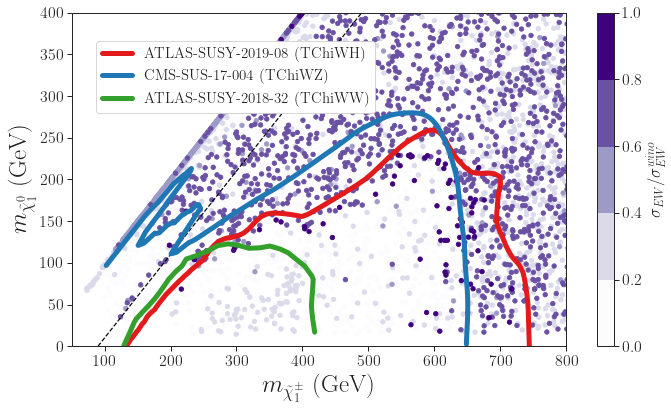

In [11]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
plt.figure(figsize=(10,6))

deleteCurves = ['CMS-EXO-19-010','ATLAS-SUSY-2016-06','ATLAS-SUSY-2016-24','CMS-SUS-13-006']

x = np.array(allowedLHC['mass.1000024'])
y = np.array(allowedLHC['mass.1000022'])
z = np.array(allowedLHC['xsecRatio'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]   

cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('YlGn',5)
cm = plt.cm.get_cmap('Purples',5)
# cm = plt.cm.get_cmap('PiYG', 10) 

plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1.0)

plt.plot([90,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if 'TDT' in ana: continue #Do not show disappearing track curve
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(0.05,0.7), framealpha=1.,fontsize=15)

plt.ylim(0,400)
plt.xlim(50,800)

plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
# plt.title("Points allowed by LHC")
plt.tight_layout()
plt.show()

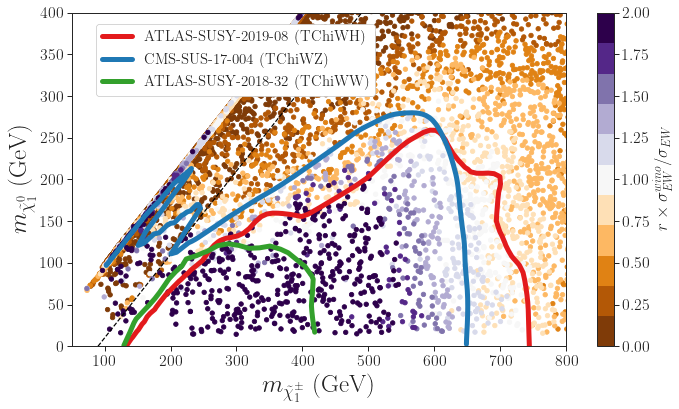

In [12]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
plt.figure(figsize=(10,6))

x = np.array(allowedLHC['mass.1000024'])
y = np.array(allowedLHC['mass.1000022'])
# z = allowedLHC['ExptRes.result0.r']
z = np.array(allowedLHC['ExptRes.result0.r']/allowedLHC['xsecRatio'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]   

cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
cm = plt.cm.get_cmap('PiYG', 11) 
cm = plt.cm.get_cmap('PuOr', 11) 
plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=0.0,vmax=2.0)

plt.plot([90,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if 'TDT' in ana: continue #Do not show disappearing track curve
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(0.05,0.75), framealpha=1.,fontsize=15)

plt.ylim(0,400)
plt.xlim(50,800)

plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$r \times \sigma_{EW}^{wino}/\sigma_{EW}$')
# plt.title("Points allowed by LHC")
plt.tight_layout()
plt.savefig('EWino_allowed_xsec.png')
plt.savefig('EWino_allowed_xsec.pdf')
plt.show()

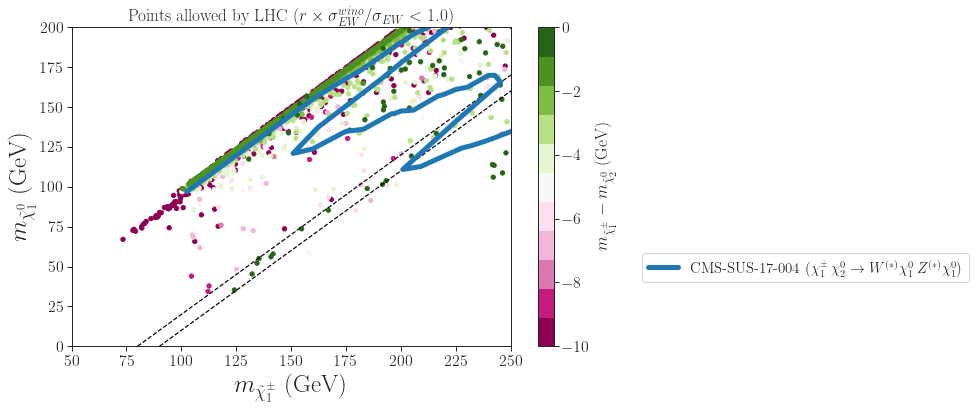

In [13]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
plt.figure(figsize=(14,6))

filtered = allowedLHC[allowedLHC['ExptRes.result0.r']/allowedLHC['xsecRatio'] < 1.0]

x = np.array(filtered['mass.1000024'])
y = np.array(filtered['mass.1000022'])
z = np.array(filtered['mass.1000024']-filtered['mass.1000023'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]   

cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
cm = plt.cm.get_cmap('PiYG', 11) 
plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=-10,vmax=0)

plt.plot([90,500],[0,410],linestyle='--',c='black')
plt.plot([80,500],[0,420],linestyle='--',c='black')


for ana in anas.index:
    if not 'CMS-SUS-17-004' in ana: continue
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    label = convertLabel(ana)
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=label)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=15)

plt.ylim(0,200)
plt.xlim(50,250)

plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$m_{\tilde{\chi}_1^\pm}-m_{\tilde{\chi}_2^0}$ (GeV)')
plt.title("Points allowed by LHC"+r' ($r \times \sigma_{EW}^{wino}/\sigma_{EW} < 1.0$)')
plt.tight_layout()
plt.show()

KeyError: 'ATLAS-SUSY-2016-24 (TChiWZ)'

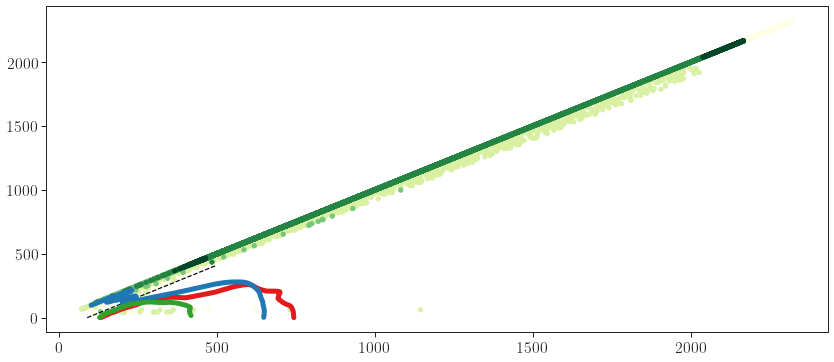

In [14]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
plt.figure(figsize=(14,6))

x = np.array(allowedLHCDD['mass.1000024'])
y = np.array(allowedLHCDD['mass.1000022'])
z = np.array(allowedLHCDD['xsecRatio'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]   

cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
cm = plt.cm.get_cmap('YlGn',5)
plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)

plt.plot([90,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if 'TDT' in ana: continue #Do not show disappearing track curve
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    if not ana in colorDict: continue
    label = convertLabel(ana)
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,500)
plt.xlim(50,1000)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
plt.title("Points allowed by LHC + Relic Density")
plt.tight_layout()
plt.show()

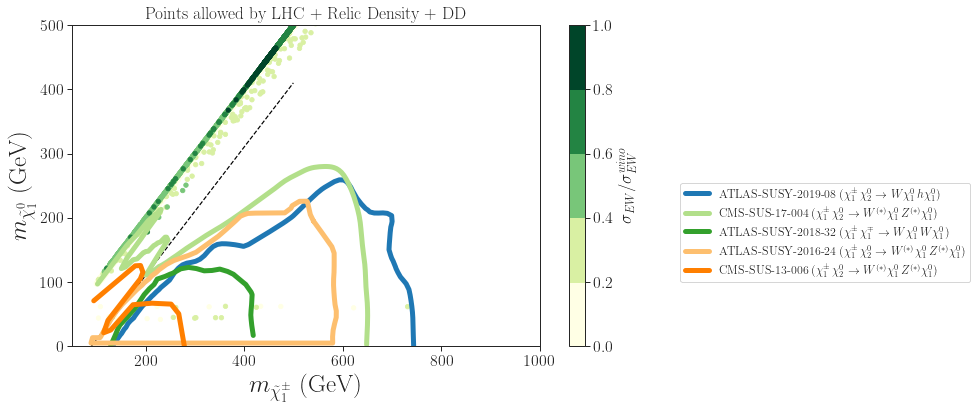

In [15]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
plt.figure(figsize=(14,6))

x = np.array(allowed['mass.1000024'])
y = np.array(allowed['mass.1000022'])
z = np.array(allowed['xsecRatio'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]   

cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Greys')
cm = plt.cm.get_cmap('YlGn',5)
plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)

plt.plot([90,500],[0,410],linestyle='--',c='black')


for ana in anas.index:
    if 'TDT' in ana: continue #Do not show disappearing track curve
    if not ana in excCurves: continue
    curve = excCurves[ana]
    color = colorDict[ana]
    label = convertLabel(ana)
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=label)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,500)
plt.xlim(50,1000)
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.colorbar(label = r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
plt.title("Points allowed by LHC + Relic Density + DD")
plt.tight_layout()
plt.show()

In [16]:
largeMu = dataDF[(dataDF['extpar.23'] > 3*dataDF['extpar.2']) & (dataDF['extpar.23'] > 3*dataDF['extpar.1'])]

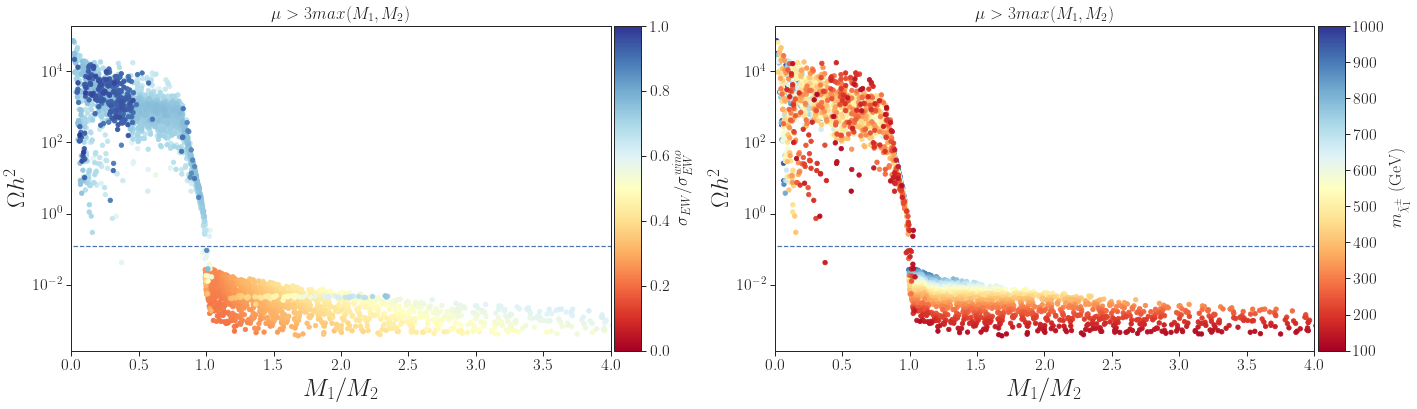

In [17]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,6))


for i,ax in enumerate(axes):
    x = np.array(largeMu['extpar.1']/largeMu['extpar.2'])
    y = np.array(largeMu['Omega'])    
    if i == 0:
        z = np.array(largeMu['xsecRatio'])
        x = x[z.argsort()]
        y = y[z.argsort()]
        z = z[z.argsort()]             
    else:        
        z = np.array(largeMu['mass.1000024'])
        x = x[(-z).argsort()]
        y = y[(-z).argsort()]
        z = z[(-z).argsort()]             
        



    cm = plt.cm.get_cmap('RdYlBu')
#     cm = plt.cm.get_cmap('Greys')
    if i == 0:
        a = ax.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)
    else:
        a = ax.scatter(x,y,c=z,s=20,cmap=cm,vmin=100,vmax=1000)
    ax.hlines(y=0.12,xmin=min(x),xmax=max(x),linestyle='--')
    ax.set_yscale('log')
    # plt.ylim(0,200)
    ax.set_xlim(0,4)
    ax.set_xlabel(r'$M_1/M_2$',fontsize = 25)
    ax.set_ylabel(r'$\Omega h^2$',fontsize = 25)
    
    
    if i == 0:
        add_colorbar(a,label= r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
    else:
        add_colorbar(a,label= r'$m_{\tilde{\chi}_1^\pm}$ (GeV)')
    ax.set_title(r"$\mu > 3 max(M_1,M_2)$")
plt.tight_layout()
plt.show()

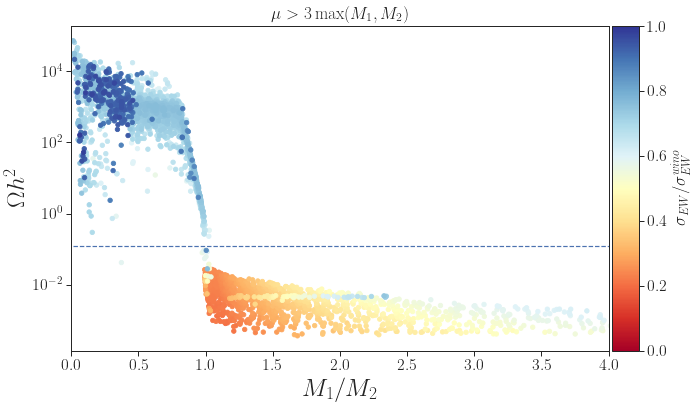

In [18]:
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(10,6))


ax = axes
x = np.array(largeMu['extpar.1']/largeMu['extpar.2'])
y = np.array(largeMu['Omega'])    
z = np.array(largeMu['xsecRatio'])
x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]             

cm = plt.cm.get_cmap('RdYlBu')
a = ax.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)
ax.hlines(y=0.12,xmin=min(x),xmax=max(x),linestyle='--')
ax.set_yscale('log')
ax.set_xlim(0,4)
ax.set_xlabel(r'$M_1/M_2$',fontsize = 25)
ax.set_ylabel(r'$\Omega h^2$',fontsize = 25)

add_colorbar(a,label= r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
ax.set_title(r"$\mu > 3 \max(M_1,M_2)$")
plt.tight_layout()
plt.savefig('EWino_relic_winobino.png')
plt.savefig('EWino_relic_winobino.pdf')
plt.show()

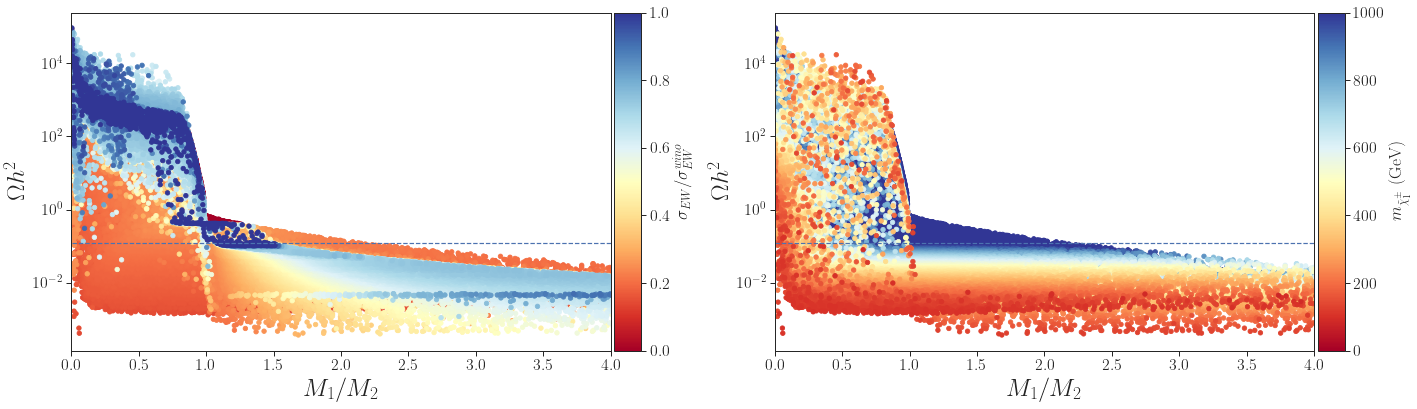

In [19]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,6))


for i,ax in enumerate(axes):
    x = np.array(dataDF['extpar.1']/dataDF['extpar.2'])
    y = np.array(dataDF['Omega'])    
    if i == 0:
        z = np.array(dataDF['xsecRatio'])
        x = x[z.argsort()]
        y = y[z.argsort()]
        z = z[z.argsort()]           
    else:
        z = np.array(dataDF['mass.1000024'])
        x = x[(-z).argsort()]
        y = y[(-z).argsort()]
        z = z[(-z).argsort()]           

  


    cm = plt.cm.get_cmap('RdYlBu')
#     cm = plt.cm.get_cmap('Greys')
    if i == 0:
        a = ax.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)
    else:
        a = ax.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1000)
    ax.hlines(y=0.12,xmin=min(x),xmax=max(x),linestyle='--')
    ax.set_yscale('log')
    # plt.ylim(0,200)
    ax.set_xlim(0,4)
    ax.set_xlabel(r'$M_1/M_2$',fontsize = 25)
    ax.set_ylabel(r'$\Omega h^2$',fontsize = 25)
    
    
    if i == 0:
        add_colorbar(a,label= r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
    else:
        add_colorbar(a,label= r'$m_{\tilde{\chi}_1^\pm}$ (GeV)')
#     ax.set_title("All (%i points)" %len(x))
    
plt.tight_layout()
plt.savefig('EWino_allowed_relic_all.png')
plt.savefig('EWino_allowed_relic_all.pdf')
plt.show()

In [20]:
lightC1 = dataDF[(dataDF['mass.1000023'] < 1000.0)]

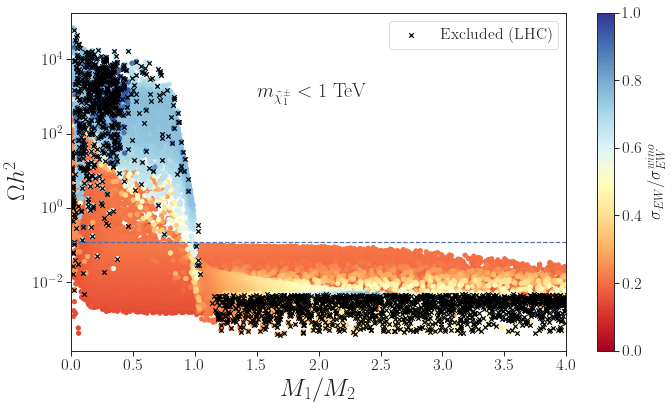

In [21]:
plt.figure(figsize=(10,6))

x = np.array(lightC1['extpar.1']/lightC1['extpar.2'])
y = np.array(lightC1['Omega'])
z = np.array(lightC1['xsecRatio'])

x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]     


cm = plt.cm.get_cmap('RdYlBu')
# cm = plt.cm.get_cmap('Greys')
plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=0,vmax=1)
plt.colorbar(label = r'$\sigma_{EW}/\sigma_{EW}^{wino}$')

xLHC = np.array(excluded['extpar.1']/excluded['extpar.2'])
yLHC = np.array(excluded['Omega'])
plt.scatter(xLHC,yLHC,c='black',s=20,marker='x',label='Excluded (LHC)')

plt.hlines(y=0.12,xmin=min(x),xmax=max(x),linestyle='--')
plt.yscale('log')
# plt.ylim(0,200)
plt.xlim(0,4)
plt.xlabel(r'$M_1/M_2$',fontsize = 25)
plt.ylabel(r'$\Omega h^2$',fontsize = 25)
plt.text(1.5,1000,r"$m_{\tilde{\chi}_1^\pm} < 1$ TeV",fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('EWino_relic_light.png')
plt.savefig('EWino_relic_light.pdf')
plt.show()